In [6]:

import HERA_hack
%load_ext autoreload
%autoreload 2


#these are for the telescope and observation
import numpy as np 
import numpy.linalg as la
import seaborn as sns
import pandas as pd
import os
from scipy import signal
import statistics 

#these are only for plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import time
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib.patches as patches
from celluloid import Camera


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [12]:
dishes1 = np.array([[0,0],[50,0]])#, [110,0]])
#observable corners of the sky [lat,long]
acorner1 = np.array([[120,270],[122,270],[120,280],[122,280]])

HERA1 = HERA_hack.telescope(dishes1, latitude=-30, channel_width=1., Tsys=300, beam_width=3, beam = 'gaussian')
obs1 = HERA_hack.observation(HERA1, 100, 100, 0.01,acorner1, 1, 0.3, norm = False, pbeam = True)
#number of pixels in the map
npix =len(obs1.observable_coordinates())

#making separate arrays of theta and phi for data vis
x = np.zeros(npix)
y = np.zeros_like(x)

for i in range(len(obs1.observable_coordinates())):
    x[i]= obs1.observable_coordinates()[i,1] #phi
    y[i] = obs1.observable_coordinates()[i,0]#theta
    


MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


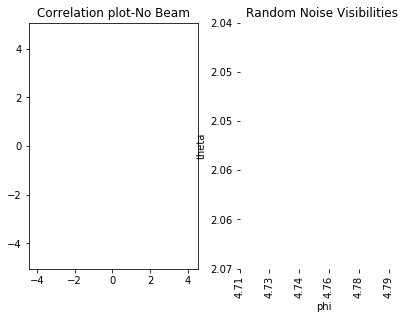

In [13]:


dishes = np.array([[0,0],[50,0],[0,60],[2,55],[47,2],[45,23],[56,21]])#,[30,115],[48,52],[100,100],[0,200],[115,30]])#,[33,31],[49,11],[21,24],[25,6],[56,9],[12,13],[16,17],[38,17],[60,14],[26,28],[6,45],[3,37],[12,55],[200,0],[145,13],[134,65],[139,163]])

acorner = np.array([[120,270],[122,280],[120,280],[122,270]])

nreal = 200

n1 = np.zeros((len(dishes)-1,nreal)) #the row is how many dished you have and the column is the realization. 
n2 = np.zeros((len(dishes)-1,nreal))


fig, (ax1,ax2) = plt.subplots(1,2)
fig.tight_layout()#if I want title to change I need to put the ax inside the loop.
camera = Camera(fig)

pix_sep = np.arange(0,680,20)

sky_map = np.real(obs1.generate_map_noise())



df_obs = pd.DataFrame.from_dict(np.asarray([x,y,sky_map]).T)
df_obs.columns = ['phi','theta','temp']



pivotted_obs= df_obs.pivot('theta','phi','temp')


h = 0 
for k in pix_sep:
   
    
    #this now only has 1 time 
    for i in range(2,len(dishes)+1):
        HERA = HERA_hack.telescope(dishes[:i], latitude=-30, channel_width=1., Tsys=300, beam_width=3, beam = 'gaussian')
        obs = HERA_hack.observation(HERA, 100, 100, 0.01,acorner, 1, 0.3, norm = False, pbeam = True)
        for j in range(nreal):
            maps = np.real(obs.generate_map_noise())
            n1[i-2,j] =  maps[10] #pick an initial pixel between 0-19 so that it's in the first column of pix
            n2[i-2,j] = maps[10+k] #add k to that pix to move across the map horizontally. 
            
    for i in range(n1.shape[0]): 
        sig_1 = statistics.stdev(n1[i])
        sig_2 = statistics.stdev(n2[i])
        n1[i] = n1[i]/sig_1
        n2[i] = n2[i]/sig_2
        
    for i in range(n1.shape[0]):

        ax1.axvline(c='grey', lw=1)
        ax1.axhline(c='grey', lw=1)


        color = ['r','b','g','y','k','m']

        ax1.scatter(n1[i],n2[i], color = color[i], alpha = 0.2)#
        ax1.plot(np.unique(n1[i]), np.poly1d(np.polyfit(n1[i], n2[i], 1))(np.unique(n1[i])), color = color[i] )#,label = '%s dishes'%(i+2))
        #ax1.legend()
        confidence_ellipse(n1[i], n2[i], ax1 , edgecolor = color[i])
        
        ax1.set_title('Correlation plot-No Beam')
        
    
    sns.heatmap(pivotted_obs,ax=ax2, cbar = False)


    # Create a Rectangle patch #(bottom left corner pix), width in pix , height in pix, other kwargs
    rect1 = patches.Rectangle((0,10),1,1,linewidth=4,edgecolor='lime',fill = False)
    rect2 = patches.Rectangle((h,10),1,1,linewidth=3,edgecolor='lime',fill = False)
    # Add the patch to the Axes
    ax2.add_patch(rect1)
    ax2.add_patch(rect2)


    ax2.set_title('Random Noise Visibilities ', y = 1.04)
    ax2.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax2.yaxis.set_major_locator(plt.MaxNLocator(6))
    xlabels = [item.get_text() for item in ax2.get_xticklabels()]
    ylabels = [item.get_text() for item in ax2.get_yticklabels()]
    ax2.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
    ax2.set_yticklabels([str(round(float(label), 2)) for label in ylabels])

    h+=1
    camera.snap()

animation = camera.animate()

from IPython.display import HTML
HTML(animation.to_jshtml())

animation.save('double_ani_beam.gif')

array([-1.,  1.,  3.,  5.,  7.,  9., 11., 13., 15., 17., 19., 21., 23.,
       25., 27., 29., 31., 33.])

In [ ]:

fig, ax= plt.subplots()

camera = Camera(fig)

for i in range(35):
    
    sky_map = np.real(obs.generate_map_noise())



    df_obs = pd.DataFrame.from_dict(np.asarray([x,y,sky_map]).T)
    df_obs.columns = ['phi','theta','temp']



    pivotted_obs= df_obs.pivot('theta','phi','temp')
    sns.heatmap(pivotted_obs,ax=ax, cbar = False)


    # Create a Rectangle patch #(bottom left corner pix), width in pix , height in pix
    rect1 = patches.Rectangle((0,0),1,1,linewidth=4,edgecolor='c',fill = False)
    rect2 = patches.Rectangle((i,0),1,1,linewidth=3,edgecolor='lime',fill = False)
    # Add the patch to the Axes
    ax.add_patch(rect1)
    ax.add_patch(rect2)


    ax.set_title('Random Noise Visibilities ', y = 1.04)
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    xlabels = [item.get_text() for item in ax.get_xticklabels()]
    ylabels = [item.get_text() for item in ax.get_yticklabels()]
    ax.set_xticklabels([str(round(float(label), 2)) for label in xlabels])
    ax.set_yticklabels([str(round(float(label), 2)) for label in ylabels])
    
    camera.snap()
    
animation = camera.animate()

from IPython.display import HTML
HTML(animation.to_jshtml())